In [1]:
# Dependencies and Setup
from bs4 import BeautifulSoup as bs
import pandas as pd
import requests
import re
import time 
import datetime 
import numpy as np
from config1 import username1,password1,host1,port1,database1
from config2 import username2,password2,host2,port2,database2
import sqlalchemy
from sqlalchemy import create_engine, func, inspect, desc
pd.options.mode.chained_assignment = None  # default='warn'
import requests
import json
from pandas.io.json import json_normalize
from timeit import default_timer as timer

In [2]:
# Database Setup
connection1=f'{username1}:{password1}@{host1}:{port1}/{database1}'
engine1 = create_engine(f'postgresql://{connection1}')

# Pull Data
state_heatmap=pd.read_sql_query('select * from state_heatmap', con=engine1)
county_heatmap=pd.read_sql_query('select * from county_heatmap', con=engine1)
state_cases=pd.read_sql_query('select * from state_cases', con=engine1)
state_deaths=pd.read_sql_query('select * from state_deaths', con=engine1)
county_cases1=pd.read_sql_query('select * from county_cases1', con=engine1)
county_cases2=pd.read_sql_query('select * from county_cases2', con=engine1)
county_cases3=pd.read_sql_query('select * from county_cases3', con=engine1)
county_deaths1=pd.read_sql_query('select * from county_deaths1', con=engine1)
county_deaths2=pd.read_sql_query('select * from county_deaths2', con=engine1)
county_deaths3=pd.read_sql_query('select * from county_deaths3', con=engine1)

# Concats
county_cases=pd.concat([county_cases1,county_cases2,county_cases3], ignore_index=True)
county_deaths=pd.concat([county_deaths1,county_deaths2,county_deaths3], ignore_index=True)

In [3]:
start = timer()
state_cases_popcorrected={}
k=0
[r,c]=state_cases.shape
for j in range (0,r):
    pop=state_heatmap.iloc[j,3]
    for i in range (1,c-7):
        if state_cases.iloc[j,i+1]>0:
            state_cases_popcorrected[k] = {"day1": (state_cases.iloc[j,i]*100000)/pop,"day2": (state_cases.iloc[j,i+1]*100000)/pop,"day3": (state_cases.iloc[j,i+2]*100000)/pop,"day4": (state_cases.iloc[j,i+3]*100000)/pop,"day5": (state_cases.iloc[j,i+4]*100000)/pop,"day6": (state_cases.iloc[j,i+5]*100000)/pop,"day7": (state_cases.iloc[j,i+6]*100000)/pop,"day8":(state_cases.iloc[j,i+7]*100000)/pop}
            k=k+1
state_cases_popcorrected = pd.DataFrame.from_dict(state_cases_popcorrected, "index")
end = timer()
print(end - start)

0.42127299999999934


In [4]:
start = timer()
state_deaths_popcorrected={}
k=0
[r,c]=state_deaths.shape
for j in range (0,r):
    pop=state_heatmap.iloc[j,3]
    for i in range (1,c-7):
        if state_deaths.iloc[j,i+1]>0:
            state_deaths_popcorrected[k] = {"casesday1": (state_cases.iloc[j,i]*100000)/pop,"casesday2": (state_cases.iloc[j,i+1]*100000)/pop,"casesday3": (state_cases.iloc[j,i+2]*100000)/pop,"casesday4": (state_cases.iloc[j,i+3]*100000)/pop,"casesday5": (state_cases.iloc[j,i+4]*100000)/pop,"casesday6": (state_cases.iloc[j,i+5]*100000)/pop,"casesday7": (state_cases.iloc[j,i+6]*100000)/pop,"day1": (state_deaths.iloc[j,i]*100000)/pop,"day2": (state_deaths.iloc[j,i+1]*100000)/pop,"day3": (state_deaths.iloc[j,i+2]*100000)/pop,"day4": (state_deaths.iloc[j,i+3]*100000)/pop,"day5": (state_deaths.iloc[j,i+4]*100000)/pop,"day6": (state_deaths.iloc[j,i+5]*100000)/pop,"day7": (state_deaths.iloc[j,i+6]*100000)/pop,"day8":(state_deaths.iloc[j,i+7]*100000)/pop}
            k=k+1
state_deaths_popcorrected = pd.DataFrame.from_dict(state_deaths_popcorrected, "index")
end = timer()
print(end - start)

0.7086615999999992


In [5]:
start = timer()
county_cases_popcorrected={}
k=0
[r,c]=county_cases.shape
for j in range (0,r):
    pop=county_heatmap.iloc[j,9]
    for i in range (3,c-7):
        if county_cases.iloc[j,i+1]>0:
            county_cases_popcorrected[k] = {"day1": (county_cases.iloc[j,i]*100000)/pop,"day2": (county_cases.iloc[j,i+1]*100000)/pop,"day3": (county_cases.iloc[j,i+2]*100000)/pop,"day4": (county_cases.iloc[j,i+3]*100000)/pop,"day5": (county_cases.iloc[j,i+4]*100000)/pop,"day6": (county_cases.iloc[j,i+5]*100000)/pop,"day7": (county_cases.iloc[j,i+6]*100000)/pop,"day8":(county_cases.iloc[j,i+7]*100000)/pop}
            k=k+1
county_cases_popcorrected = pd.DataFrame.from_dict(county_cases_popcorrected, "index")
cases_popcorrected=pd.concat([state_cases_popcorrected,county_cases_popcorrected])
end = timer()
print(end - start)

22.082945600000002


In [6]:
start = timer()
county_deaths_popcorrected={}
k=0
[r,c]=county_deaths.shape
for j in range (0,r):
    pop=county_heatmap.iloc[j,9]
    for i in range (3,c-7):
        if county_deaths.iloc[j,i+1]>0:
            county_deaths_popcorrected[k] = {"casesday1": (county_cases.iloc[j,i]*100000)/pop,"casesday2": (county_cases.iloc[j,i+1]*100000)/pop,"casesday3": (county_cases.iloc[j,i+2]*100000)/pop,"casesday4": (county_cases.iloc[j,i+3]*100000)/pop,"casesday5": (county_cases.iloc[j,i+4]*100000)/pop,"casesday6": (county_cases.iloc[j,i+5]*100000)/pop,"casesday7": (county_cases.iloc[j,i+6]*100000)/pop,"day1": (county_deaths.iloc[j,i]*100000)/pop,"day2": (county_deaths.iloc[j,i+1]*100000)/pop,"day3": (county_deaths.iloc[j,i+2]*100000)/pop,"day4": (county_deaths.iloc[j,i+3]*100000)/pop,"day5": (county_deaths.iloc[j,i+4]*100000)/pop,"day6": (county_deaths.iloc[j,i+5]*100000)/pop,"day7": (county_deaths.iloc[j,i+6]*100000)/pop,"day8":(county_deaths.iloc[j,i+7]*100000)/pop}
            k=k+1
county_deaths_popcorrected = pd.DataFrame.from_dict(county_deaths_popcorrected, "index")
deaths_popcorrected=pd.concat([state_deaths_popcorrected,county_deaths_popcorrected])
end = timer()
print(end - start)

22.4339095


In [7]:
X = cases_popcorrected[['day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7']]
y = cases_popcorrected['day8'].values.reshape(-1, 1)
print(X.shape, y.shape)

(380148, 7) (380148, 1)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
# from sklearn.preprocessing import StandardScaler

# # Create a StandardScater model and fit it to the training data

# ### BEGIN SOLUTION
# X_scaler = StandardScaler().fit(X_train)
# y_scaler = StandardScaler().fit(y_train)
# ### END SOLUTION

In [10]:
# # Transform the training and testing data using the X_scaler and y_scaler models

# ### BEGIN SOLUTION
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)
# y_train_scaled = y_scaler.transform(y_train)
# y_test_scaled = y_scaler.transform(y_test)
# ### END SOLUTION

In [11]:
# Create a LinearRegression model and fit it to the scaled training data

### BEGIN SOLUTION
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
### END SOLUTION

LinearRegression()

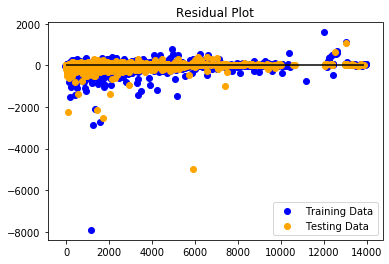

In [12]:
### BEGIN SOLUTION
import matplotlib.pyplot as plt
predictions = model.predict(X_test)
model.fit(X_train, y_train)
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()
### END SOLUTION

In [13]:
### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 837.7125965352924, R2: 0.9982667620466097


In [14]:
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train, y_train)

predictions = lasso.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = lasso.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 898.376566112584, R2: 0.9981412475265827


C:\Users\Henry Randall\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120442067.34860948, tolerance: 13768253.619673869
  positive)


In [15]:
# Ridge model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train, y_train)

predictions = ridge.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = ridge.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 837.7125965332393, R2: 0.9982667620466139


In [16]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train, y_train)

predictions = elasticnet.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = elasticnet.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 898.3806555336145, R2: 0.9981412390655189


C:\Users\Henry Randall\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120447914.03863977, tolerance: 13768253.619673869
  positive)


In [17]:
print(f"Training Data Score: {model.score(X_train, y_train)}")
print(f"Testing Data Score: {model.score(X_test, y_test)}")

Training Data Score: 0.9984749191850502
Testing Data Score: 0.9982667620466097


In [18]:
predictions = model.predict(X_test)
data = np.round(predictions, 0)
print(f"First 10 Predictions:   {data[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   [[ 204.]
 [ 186.]
 [  41.]
 [ 565.]
 [3233.]
 [ 258.]
 [ 453.]
 [  38.]
 [ 641.]
 [1674.]]
First 10 Actual labels: [[202.21982213847463], [186.31436314363143], [37.885963250615646], [570.6179467932162], [3239.271017048795], [244.0419447092469], [455.87292542203863], [35.03503503503504], [680.8510638297872], [1646.774437226167]]


In [19]:
pd.DataFrame({"Prediction": [data], "Actual": [y_test]}).reset_index(drop=True)

,Prediction,Actual
0,"[[204.0], [186.0], [41.0], [565.0], [3233.0], ...","[[202.21982213847463], [186.31436314363143], [..."


In [20]:
data

array([[204.],
       [186.],
       [ 41.],
       ...,
       [  9.],
       [495.],
       [118.]])

In [21]:
y_test

array([[202.21982214],
       [186.31436314],
       [ 37.88596325],
       ...,
       [  5.96587519],
       [499.58972646],
       [115.09963312]])

In [22]:
model

LinearRegression()

In [23]:
#To retrieve the intercept:
print(model.intercept_)
#For retrieving the slope:
print(model.coef_)

[2.61145164]
[[-0.05288652  0.01724225 -0.06653097  0.03490661  0.03230397 -0.2233047
   1.26147011]]


Optimizations and Testing

In [24]:
start = timer()
state_cases_processed=pd.DataFrame([],columns=['day1','day2','day3','day4','day5','day6','day7','day8'])
state_cases_popcorrected=pd.DataFrame([],columns=['day1','day2','day3','day4','day5','day6','day7','day8'])
cols=state_cases_processed.columns
[r,c]=state_cases.shape
for j in range (0,r):
    pop=state_heatmap.iloc[j,3]
    for i in range (1,c-7):
        temp=pd.DataFrame(state_cases.iloc[j,i:i+8]).T
        if temp.iloc[0,1]>0:
            pop_temp=(temp*100000)/pop
            new_cols = {x: y for x, y in zip(temp.columns, cols)}
            state_cases_processed = state_cases_processed.append(temp.rename(columns=new_cols))
            state_cases_popcorrected = state_cases_popcorrected.append(pop_temp.rename(columns=new_cols))
end = timer()
print(end - start)

22.874931000000004


In [25]:
start = timer()
# state_cases_processed=pd.DataFrame([],columns=['day1','day2','day3','day4','day5','day6','day7','day8'])
state_cases_popcorrected=pd.DataFrame([],columns=['day1','day2','day3','day4','day5','day6','day7','day8'])
cols=state_cases_popcorrected.columns
[r,c]=state_cases.shape
for j in range (0,r):
    pop=state_heatmap.iloc[j,3]
    for i in range (1,c-7):
        temp=pd.DataFrame(state_cases.iloc[j,i:i+8]).T
        if temp.iloc[0,1]>0:
            pop_temp=(temp*100000)/pop
            new_cols = {x: y for x, y in zip(temp.columns, cols)}
#             state_cases_processed = state_cases_processed.append(temp.rename(columns=new_cols))
            state_cases_popcorrected = state_cases_popcorrected.append(pop_temp.rename(columns=new_cols))
end = timer()
print(end - start)

17.131910000000005


In [26]:
start = timer()
# state_cases_processed=pd.DataFrame([],columns=['day1','day2','day3','day4','day5','day6','day7','day8'])
state_cases_popcorrected=pd.DataFrame([],columns=['day1','day2','day3','day4','day5','day6','day7','day8'])
cols=state_cases_popcorrected.columns
[r,c]=state_cases.shape
for j in range (0,r):
    pop=state_heatmap.iloc[j,3]
    for i in range (1,c-7):
        if state_cases.iloc[j,i+1]>0:
            temp=pd.DataFrame(state_cases.iloc[j,i:i+8]).T
            pop_temp=(temp*100000)/pop
            new_cols = {x: y for x, y in zip(temp.columns, cols)}
#             state_cases_processed = state_cases_processed.append(temp.rename(columns=new_cols))
            state_cases_popcorrected = state_cases_popcorrected.append(pop_temp.rename(columns=new_cols))
end = timer()
print(end - start)

14.715150899999998


In [27]:
state_cases.iloc[j,i]

2520

In [28]:
start = timer()
state_cases_popcorrected={}
k=0
[r,c]=state_cases.shape
for j in range (0,r):
    pop=state_heatmap.iloc[j,3]
    for i in range (1,c-7):
        if state_cases.iloc[j,i+1]>0:
            state_cases_popcorrected[k] = {"day1": (state_cases.iloc[j,i]*100000)/pop,"day2": (state_cases.iloc[j,i+1]*100000)/pop,"day3": (state_cases.iloc[j,i+2]*100000)/pop,"day4": (state_cases.iloc[j,i+3]*100000)/pop,"day5": (state_cases.iloc[j,i+4]*100000)/pop,"day6": (state_cases.iloc[j,i+5]*100000)/pop,"day7": (state_cases.iloc[j,i+6]*100000)/pop,"day8":(state_cases.iloc[j,i+7]*100000)/pop}
            k=k+1
state_cases_popcorrected = pd.DataFrame.from_dict(state_cases_popcorrected, "index")
end = timer()
print(end - start)

0.43958419999998455


In [29]:
state_cases_popcorrected

,day1,day2,day3,day4,day5,day6,day7,day8
0,0.000000,0.101975,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803
1,0.101975,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860
2,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733
3,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733,3.202000
4,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733,3.202000,3.997402
...,...,...,...,...,...,...,...,...
7625,405.522851,415.544294,422.628417,427.639138,435.414395,447.336456,454.075012,464.096455
7626,415.544294,422.628417,427.639138,435.414395,447.336456,454.075012,464.096455,471.007794
7627,422.628417,427.639138,435.414395,447.336456,454.075012,464.096455,471.007794,478.437484
7628,427.639138,435.414395,447.336456,454.075012,464.096455,471.007794,478.437484,485.176040


In [30]:
state_cases_popcorrected

,day1,day2,day3,day4,day5,day6,day7,day8
0,0.000000,0.101975,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803
1,0.101975,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860
2,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733
3,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733,3.202000
4,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733,3.202000,3.997402
...,...,...,...,...,...,...,...,...
7625,405.522851,415.544294,422.628417,427.639138,435.414395,447.336456,454.075012,464.096455
7626,415.544294,422.628417,427.639138,435.414395,447.336456,454.075012,464.096455,471.007794
7627,422.628417,427.639138,435.414395,447.336456,454.075012,464.096455,471.007794,478.437484
7628,427.639138,435.414395,447.336456,454.075012,464.096455,471.007794,478.437484,485.176040


In [31]:
cases_popcorrected

,day1,day2,day3,day4,day5,day6,day7,day8
0,0.000000,0.101975,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803
1,0.101975,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860
2,0.142764,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733
3,0.224344,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733,3.202000
4,0.591452,0.795401,1.040140,1.590803,2.161860,2.671733,3.202000,3.997402
...,...,...,...,...,...,...,...,...
372513,57.745056,57.745056,57.745056,57.745056,72.181319,72.181319,72.181319,72.181319
372514,57.745056,57.745056,57.745056,72.181319,72.181319,72.181319,72.181319,72.181319
372515,57.745056,57.745056,72.181319,72.181319,72.181319,72.181319,72.181319,72.181319
372516,57.745056,72.181319,72.181319,72.181319,72.181319,72.181319,72.181319,72.181319


In [32]:
deaths_popcorrected

,casesday1,casesday2,casesday3,casesday4,casesday5,casesday6,casesday7,day1,day2,day3,day4,day5,day6,day7,day8
0,4.935567,7.770459,10.544167,11.971810,14.154065,16.825798,18.335021,0.000000,0.020395,0.020395,0.081580,0.081580,0.203949,0.203949,0.469083
1,7.770459,10.544167,11.971810,14.154065,16.825798,18.335021,20.129773,0.020395,0.020395,0.081580,0.081580,0.203949,0.203949,0.469083,0.550662
2,10.544167,11.971810,14.154065,16.825798,18.335021,20.129773,21.618601,0.020395,0.081580,0.081580,0.203949,0.203949,0.469083,0.550662,0.652637
3,11.971810,14.154065,16.825798,18.335021,20.129773,21.618601,25.146920,0.081580,0.081580,0.203949,0.203949,0.469083,0.550662,0.652637,0.775006
4,14.154065,16.825798,18.335021,20.129773,21.618601,25.146920,30.490385,0.081580,0.203949,0.203949,0.469083,0.550662,0.652637,0.775006,0.897376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197613,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,11.841326,11.841326,11.841326,11.841326,11.841326,11.841326,11.841326,11.841326
197614,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,11.841326,11.841326,11.841326,11.841326,11.841326,11.841326,11.841326,11.841326
197615,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,11.841326,11.841326,11.841326,11.841326,11.841326,11.841326,11.841326,11.841326
197616,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,260.509177,11.841326,11.841326,11.841326,11.841326,11.841326,11.841326,11.841326,11.841326
